## Hassan Albujasim, Stefan Bordei

# Multiprocessing using Pools 
A simple framework for assessing the impact of multiprocessing on runtime on a multi-core machine. 

In [1]:
import time
from time import perf_counter_ns
import math
import multiprocessing
from multiprocessing import Pool
import matplotlib.pyplot as plt
import os
import sys

# A function for timing a job that uses a pool of processes.
#  f is a function that takes a single argument
#  data is an array of arguments on which f will be mapped
#  pool_size is the number of processes in the pool. 
def pool_process(f, data, pool_size):
    tp1 = time.time()
    pool = Pool(processes=pool_size) # initialize the Pool.
    result = pool.map(f, data)       # map f to the data using the Pool of processes to do the work 
    pool.close() # No more processes
    pool.join()  # Wait for the pool processing to complete. 
    print("Results", result)
    print("Overall Time:", int(time.time()-tp1))
 

In [2]:
def my_func(x):
    s = math.sqrt(x)
    return s

In [3]:
# This verbose version shows which process in the pool is running each task. 
def my_func_verbose(x):
    s = math.sqrt(x)
    print("Task", multiprocessing.current_process(), x, s)
    return s

In [4]:
dataRange = range(10)

Use the pool_process function to apply my_func to the data in dataRange.  
This task is so light it requires very little processing time. 

In [5]:
pool_process(my_func, dataRange, 1)
#pool_process(my_func_verbose, dataRange, 2)

Results [0.0, 1.0, 1.4142135623730951, 1.7320508075688772, 2.0, 2.23606797749979, 2.449489742783178, 2.6457513110645907, 2.8284271247461903, 3.0]
Overall Time: 0


## A naive function for checking primes 

In [6]:
def check_prime(num):
    t1 = time.time()
    res = False
    if num > 0:
        # check for factors
        for i in range(2,num):
            if (num % i) == 0:
                print(num,"is not a prime number")
                print(i,"times",num//i,"is",num)
                print("Time:", int(time.time()-t1))
                break
        else:
            print(num,"is a prime number")
            print("Time:", time.time()-t1) 
            res = True
            # if input number is less than
            # or equal to 1, it is not prime
    return res


In [7]:
check_prime(15488801)

15488801 is a prime number
Time: 1.0470309257507324


True

In [8]:
check_prime(15488803)

15488803 is not a prime number
11 times 1408073 is 15488803
Time: 0


False

# Task 1

Before running any of the functions `pyper system tune` was used in order to tune the system for benchmarking in python. Due to the fact that we are using the `pool_process` function the affinity was not set to specific cores but was left as default.

Functions:
- pool_process():
 - removed all the print statements to make the function silent
 - returned the runtime of the function for comparisons and plots
- check_prime():
 - removed all the print statements to make the function silent
- bench():
 - used to run a function a number of times (default 100) and return the avg time

The `check_prime()` function will be run on a list of large prime numbers in order to extend the runtimes and also to better understand how the pool size affects the running times.

In [4]:
def pool_process_time(f, data, pool_size):
    tp1 = time.time()
    pool = Pool(processes=pool_size) # initialize the Pool.
    result = pool.map(f, data)       # map f to the data using the Pool of processes to do the work 
    pool.close() # No more processes
    pool.join()  # Wait for the pool processing to complete. 
    return int(time.time() - tp1) # return runtime for plotting

def check_prime_2(num):
    t1 = time.time()
    res = False
    if num > 0:
        # check for factors
        for i in range(2,num):
            if (num % i) == 0:
                break
        else:
            res = True
    return res

def bench(func, target, data, cores, reps=100):
    """
        Benchmarking.
    """
    start = perf_counter_ns()
    for _ in range(reps):
        func(target, data, cores)
    return (perf_counter_ns() - start) / reps

In [10]:
check_work = [15485863, 32452843, 49979687, 67867967, 86028121, 104395301, 122949823]

# Varying pool size

### The following functions were run on Linux and might work differently on Windows/MacOS.

The `check_prime` function will be run with different pool sizes in order to see how this affects the running time. The decision to run it on a list of 1 to 15 cores was made even though the machines running the function had 4 physical cores and 8 logical cores as `os.cpu_count()` shows below.

In [11]:
print(f"Number of CPUs: {os.cpu_count()}\nProcess with PID {os.getpid()} is eligible to run on the following cores: {os.sched_getaffinity(os.getpid())}\nPlatform: {sys.platform}")

Number of CPUs: 8
Process with PID 3446 is eligible to run on the following cores: {0, 1, 2, 3, 4, 5, 6, 7}
Platform: linux


In [26]:
cores = list(range(1,15))

## Running the `check_prime` function without `bench`

In [27]:
linear_times_primes_raw = [pool_process_time(check_prime_2, check_work, i) for i in cores]

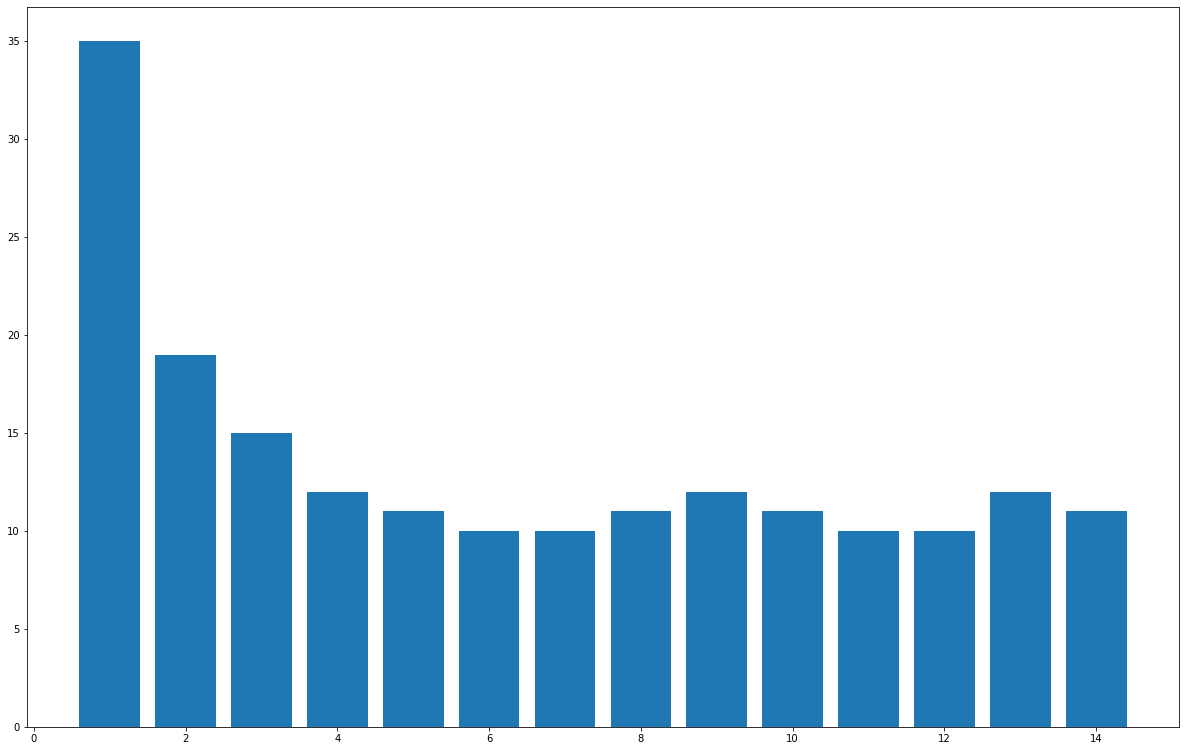

In [29]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_axes([0,0,1,1])
pool = [i for i in cores]
times = [i for i in linear_times_primes_raw]
ax.bar(pool,times)
plt.show()

## Running the `check_prime` function with `bench` in order to get more accurate data

In [12]:
linear_times_primes = [bench(pool_process_time, check_prime_2, check_work, i, 10) for i in cores]

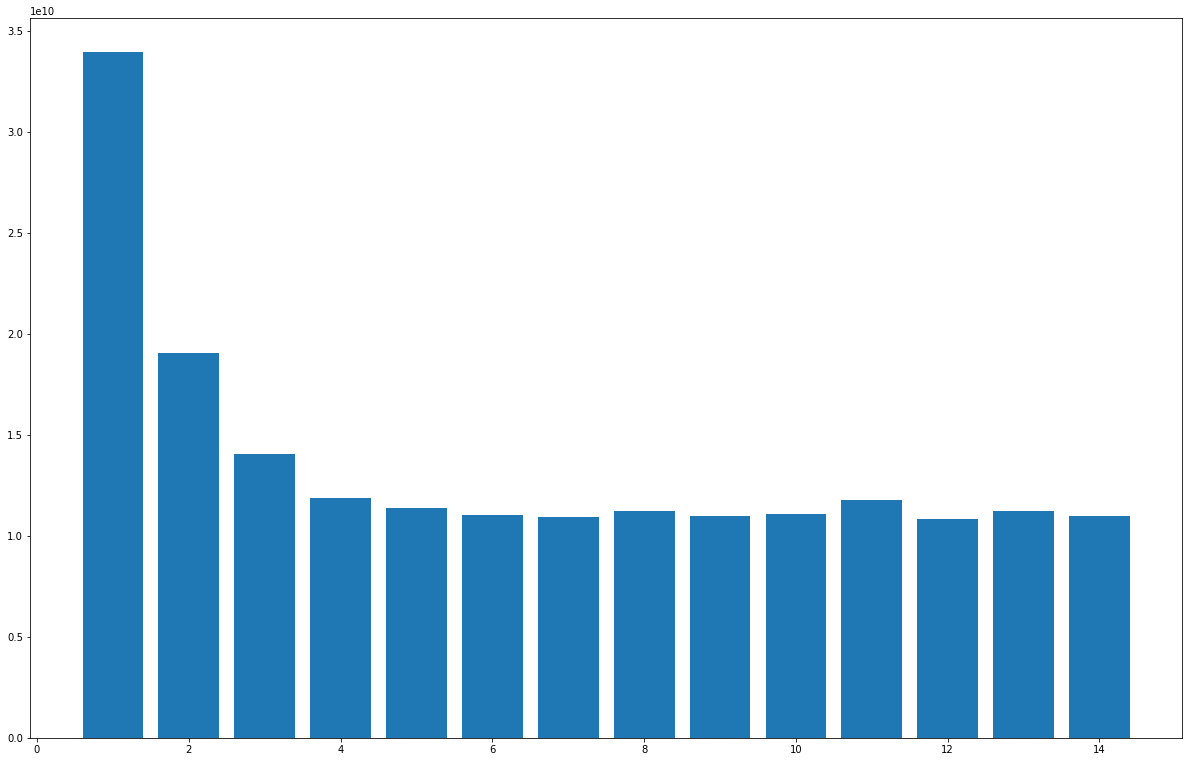

In [13]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_axes([0,0,1,1])
pool = [i for i in cores]
times = [i for i in linear_times_primes]
ax.bar(pool,times)
plt.show()

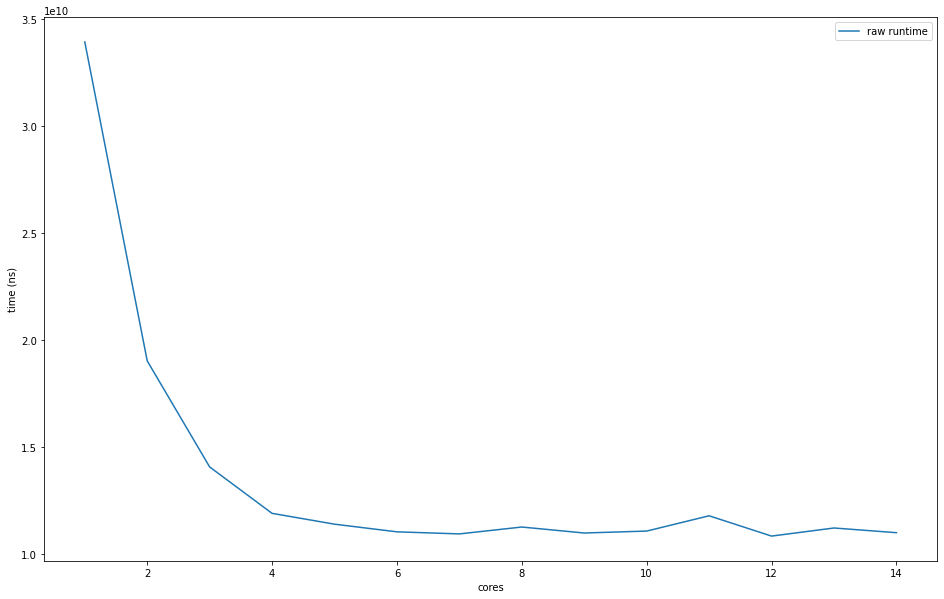

In [33]:
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(cores, linear_times_primes, label='raw runtime')
ax.set(xlabel='cores', ylabel='time (ns)')
ax.legend()
plt.show()

In [16]:
check_work_slices = []
for i in range(len(check_work)):
    check_work_slices.append(check_work[:i])

times_list_size_single_core = [bench(pool_process_time, check_prime_2, i, 1, 10) for i in check_work_slices]
times_list_size_dual_core = [bench(pool_process_time, check_prime_2, i, 2, 10) for i in check_work_slices]
times_list_size_quad_core = [bench(pool_process_time, check_prime_2, i, 4, 10) for i in check_work_slices]
times_list_size_octal_core = [bench(pool_process_time, check_prime_2, i, 8, 10) for i in check_work_slices]
times_list_size_test_core = [bench(pool_process_time, check_prime_2, i, 15, 10) for i in check_work_slices]

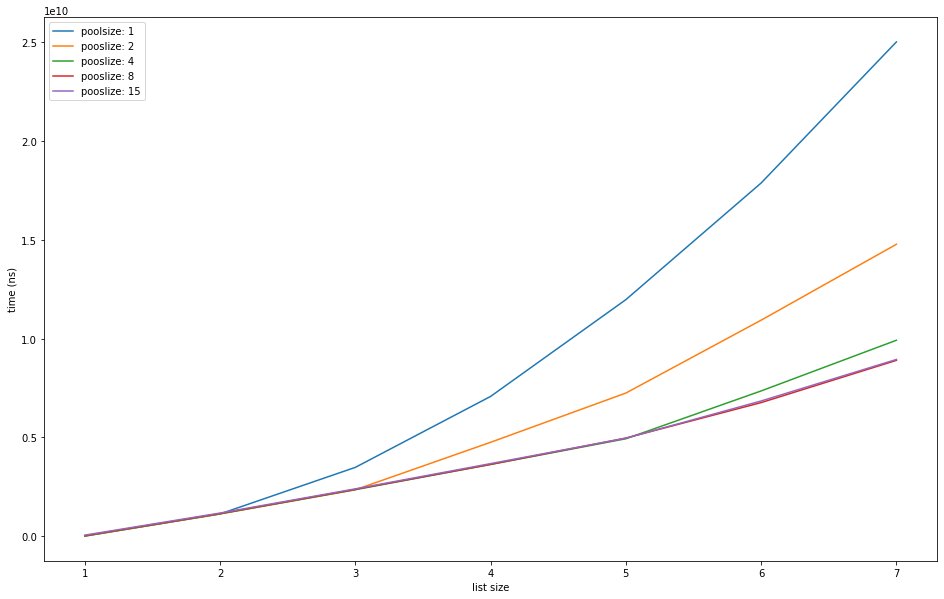

In [49]:
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(range(1, len(check_work) + 1), times_list_size_single_core, label='poolsize: 1')
ax.plot(range(1, len(check_work) + 1), times_list_size_dual_core, label='pooslize: 2')
ax.plot(range(1, len(check_work) + 1), times_list_size_quad_core, label='pooslize: 4')
ax.plot(range(1, len(check_work) + 1), times_list_size_octal_core, label='pooslize: 8')
ax.plot(range(1, len(check_work) + 1), times_list_size_test_core, label='pooslize: 15')
ax.set(xlabel='list size', ylabel='time (ns)')
ax.legend()
plt.show()

# Conclusion Task 1

The time difference between using a pool size of 1 and 2 is noticeable but after that the increase in speed is logarithmic. Increasing the pool size will only have an impact up to a certain point, after that the difference will not be noticeable and the speed increase tends to flatten out.

### Running the `check_prime` function with different pool sizes and different input sizes:

In order to check how the processes are run in parallel we used as input arrays of different sizes. In order to do this we ran the function on slices of the initial input array.

The function was run using pool sizes of 1, 2, 4, 8, 15.

As expected with every increase of the input size the run time of the function increases as well.
Using one element shows no correlation between the pool size and the run time but as we added elements to the input one by one we the direct correlation between the pool size and the time it takes to run the function becomes obvious.

For example using a pool size of 2 and 2 processes we can see that there is no jump in the run time as using a pool size of 1, this makes sense as using a pool size of 2 allows for the function to be ran in parallel on the 2 elements in the array as oppose to using a pool size of 1 where the function can be ran on the second element after the first one is finished.

## Task 2

For the second task we decided to use a factorial function on an array of numbers. We tried to use a larger number as the upper limit in order to force python to use big numbers. Using big numbers would increase the time required to run the function.

In [2]:
def factorial(num):
    """
        Simple factorial.
    """
    res = 1
    if num == 0:
        return 1
    for i in range(1, num + 1):
        res *= i
    return res

In [16]:
N = 10000
input_arr = list(range(N))

times_factorial_1 = pool_process_time(factorial, input_arr, 1)
times_factorial_2 = pool_process_time(factorial, input_arr, 2)
times_factorial_3 = pool_process_time(factorial, input_arr, 3)
times_factorial_4 = pool_process_time(factorial, input_arr, 4)

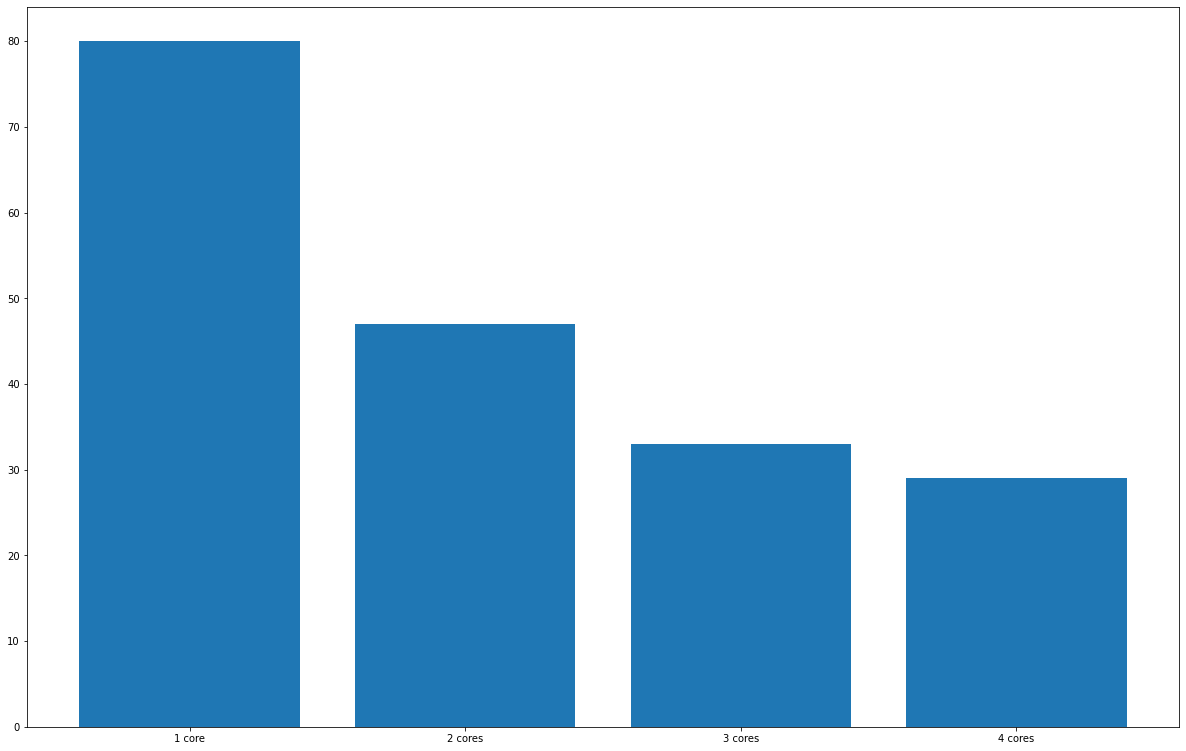

In [28]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_axes([0,0,1,1])
pool = ['1 core', '2 cores', '3 cores', '4 cores']
times = [times_factorial_1, times_factorial_2, times_factorial_3, times_factorial_4]
ax.bar(pool,times)
plt.show()

# Using an affinity mask



In [44]:
print("Number of CPUs:", os.cpu_count())
pid = os.getpid()
affinity = os.sched_getaffinity(pid)
print("Process is eligible to run on:", affinity)
affinity_mask = {0,1}
print("PID: %d" %pid)
os.sched_setaffinity(pid, affinity_mask)
print("CPU affinity mask is modified for process id % s" % pid) 
pid = os.getpid()
affinity = os.sched_getaffinity(pid)
print("Now, process is eligible to run on:", affinity)

Number of CPUs: 8
Process is eligible to run on: {0, 1, 2, 3, 4, 5, 6, 7}
PID: 22812
CPU affinity mask is modified for process id 22812
Now, process is eligible to run on: {0, 1}


In [45]:
times_factorial_1a = pool_process_time(factorial, input_arr, 1)
times_factorial_2a = pool_process_time(factorial, input_arr, 2)
times_factorial_3a = pool_process_time(factorial, input_arr, 3)
times_factorial_4a = pool_process_time(factorial, input_arr, 4)

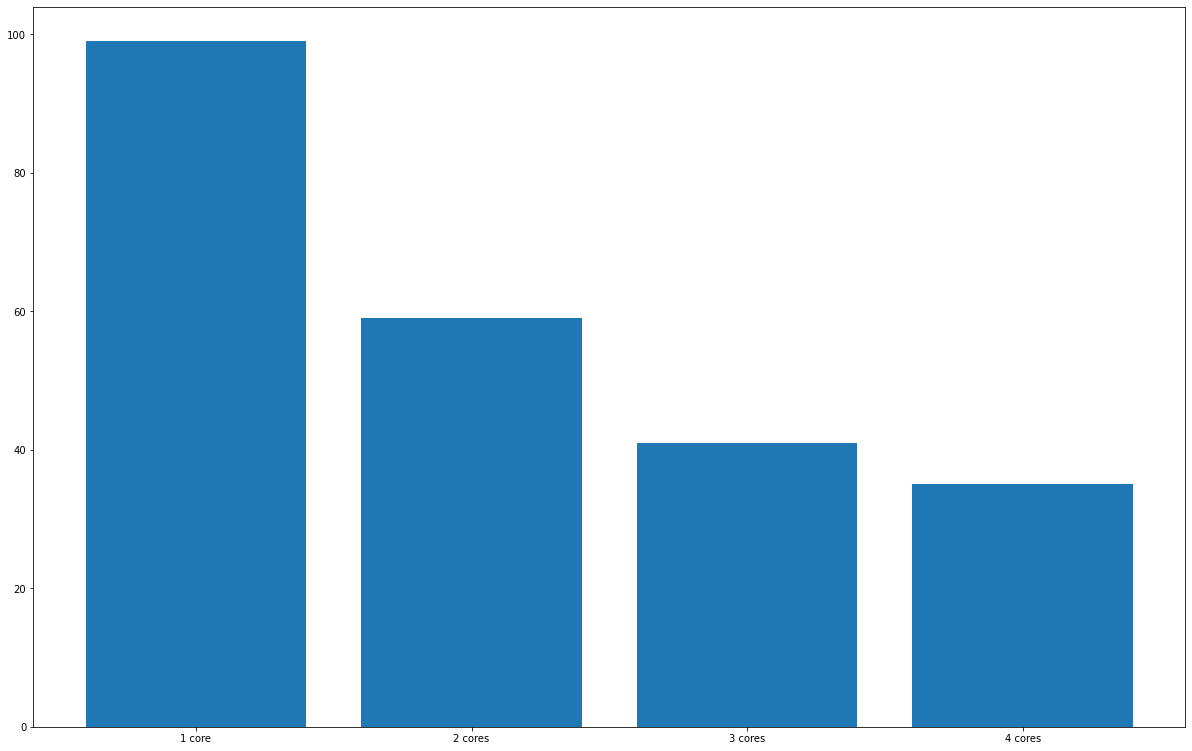

In [46]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_axes([0,0,1,1])
pool = ['1 core', '2 cores', '3 cores', '4 cores']
times = [times_factorial_1a, times_factorial_2a, times_factorial_3a, times_factorial_4a]
ax.bar(pool,times)
plt.show()

# Conclusion Task 2

As expected the `factorial` function that forced python to use big numbers gave similar results to the `check_prime` function when using multiprocessing.
We also tried to set an affinity mask for the first 2 logical cores to see if the multiprocessing will be affected and, as shown above, all the physical cores will still be used and the affinity mask is ignored.  